In [1]:
import json
import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'times new roman'
rcParams['font.size'] = 12
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Data Loading and Preprocessing

In [7]:
# EPA Smart Location dataframes
csv_path = 'Hamilton_SLD.csv'
oh_df = pd.read_csv(csv_path,header=1)
csv_path = 'NorthKY_SLD.csv'
ky_df = pd.read_csv(csv_path,header=1)

# Shapefile geodataframes
oh_gdf = gpd.read_file('tl_2019_39_bg/tl_2019_39_bg.shp')
oh_filtered_gdf = oh_gdf[(oh_gdf['STATEFP'] == '39') & (oh_gdf['COUNTYFP'] == '061')]
oh_sorted_gdf = oh_filtered_gdf.sort_values(by='TRACTCE')
oh_gdf = oh_sorted_gdf


ky_gdf = gpd.read_file('tl_2019_21_bg/tl_2019_21_bg.shp')
ky_filtered_gdf = ky_gdf[(ky_gdf['STATEFP'].isin(['21'])) & (ky_gdf['COUNTYFP'].isin(['037', '117']))]
ky_sorted_gdf = ky_filtered_gdf.sort_values(by='TRACTCE')
ky_gdf = ky_sorted_gdf

# Merging Ohio
oh_df.set_index(['TRACTCE','BLKGRPCE'])
oh_gdf.set_index(['TRACTCE','BLKGRPCE'])

oh_gdf['STATEFP'] = oh_gdf['STATEFP'].astype(int)
oh_gdf['COUNTYFP'] = oh_gdf['COUNTYFP'].astype(int)
oh_gdf['TRACTCE'] = oh_gdf['TRACTCE'].astype(int)
oh_gdf['BLKGRPCE'] = oh_gdf['BLKGRPCE'].astype(int)

oh_df['STATEFP'] = oh_df['STATEFP'].astype(int)
oh_df['COUNTYFP'] = oh_df['COUNTYFP'].astype(int)
oh_df['TRACTCE'] = oh_df['TRACTCE'].astype(int)
oh_df['BLKGRPCE'] = oh_df['BLKGRPCE'].astype(int)

# Merge the DataFrames based on the specified columns
oh_merged = oh_gdf.merge(oh_df, on=['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE'], how='outer')
#nan_info = oh_merged.isna().sum()

# Merging Kentucky
ky_df.set_index(['TRACTCE','BLKGRPCE'])
ky_gdf.set_index(['TRACTCE','BLKGRPCE'])

ky_gdf['STATEFP'] = ky_gdf['STATEFP'].astype(int)
ky_gdf['COUNTYFP'] = ky_gdf['COUNTYFP'].astype(int)
ky_gdf['TRACTCE'] = ky_gdf['TRACTCE'].astype(int)
ky_gdf['BLKGRPCE'] = ky_gdf['BLKGRPCE'].astype(int)

ky_df['STATEFP'] = ky_df['STATEFP'].astype(int)
ky_df['COUNTYFP'] = ky_df['COUNTYFP'].astype(int)
ky_df['TRACTCE'] = ky_df['TRACTCE'].astype(int)
ky_df['BLKGRPCE'] = ky_df['BLKGRPCE'].astype(int)

# Merge the DataFrames based on the specified columns
ky_merged = ky_gdf.merge(ky_df, on=['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE'],how='outer')


oh_merged.to_csv('generated/OH_merged.csv', index=False)
ky_merged.to_csv('generated/KY_merged.csv', index=False)

cinci_north_threshold = 39.20523504504504 # 39.178235
cinci_west_threshold = -84.56495903511477 #-84.578171
cinci_east_threshold = -84.40509096488523 #-84.404453
ky_south_threshold = 39.03801495495496 #39.066089


oh_cropped = oh_merged[oh_merged.geometry.centroid.y < cinci_north_threshold]
oh_cropped = oh_cropped[oh_cropped.geometry.centroid.x > cinci_west_threshold]
oh_cropped = oh_cropped[oh_cropped.geometry.centroid.x < cinci_east_threshold]
ky_cropped = ky_merged[ky_merged.geometry.centroid.y > ky_south_threshold]

oh_cropped.to_csv('generated/OH_trimmed.csv', index=False)
ky_cropped.to_csv('generated/KY_trimmed.csv', index=False)
ohky_trimmed = pd.concat([oh_cropped, ky_cropped], ignore_index=True)
ohky_trimmed.to_csv('generated/ohky_trimmed.csv',index=False)
df=ohky_trimmed
backup = df.copy(deep=True)
kepler_map = KeplerGl(height=600)
kepler_map.add_data(data=df, name='filtered_census_blocks')
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'filtered_census_blocks': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …

# Utility Functions

In [8]:
# Feature -> Description mapping
field_description_list = [
    # Population, Households and Working Age
    ('TotPop', 'Population, 2018'),
    ('CountHU', 'Housing units, 2018'),
    ('HH', 'Households (occupied housing units), 2018'),
    ('P_WrkAge', 'Percent of population that is working aged 18 to 64 years, 2018'),
    # Automobile ownership
    ('AutoOwn0', 'Number of households in CBG that own zero automobiles, 2018'),
    ('Pct_AO0', 'Percent of zero-car households in CBG, 2018'),
    ('AutoOwn1', 'Number of households in CBG that own one automobile, 2018'),
    ('Pct_AO1', 'Percent of one-car households in CBG, 2018'),
    ('AutoOwn2p', 'Number of households in CBG that own two or more automobiles, 2018'),
    ('Pct_AO2p', 'Percent of two-plus-car households in CBG, 2018'),
    # Workers, Salary And Employment
    ('Workers', 'Count of workers in CBG (home location), 2017'),
    ('R_LowWageWk', 'Count of workers earning $1250/month or less (home location), 2017'),
    #('R_MedWageWk', 'Count of workers earning more than $1250/month but less than $3333/month (home location), 2017'),
    #('R_HiWageWk', 'Count of workers earning $3333/month or more (home location), 2017'),
    ('R_PCTLOWWAGE', 'Percent of low wage workers in a CBG (home location), 2017'),
    ('TotEmp', 'Total employment, 2017'),
    #('E8_Ret', 'Retail jobs within an 8-tier employment classification scheme (LEHD: CNS07), 2017'),
    #('E8_off', 'Office jobs within an 8-tier employment classification scheme LEHD'),
    #('E8_Ind', 'Industrial jobs within an 8-tier employment classification scheme LEHD'),
    #('E8_Svc', 'Service jobs within an 8-tier employment classification scheme LEHD'),
    #('E8_Ent', 'Entertainment jobs within an 8-tier employment classification scheme LEHD'),
    #('E8_Ed', 'Education jobs within an 8-tier employment classification scheme LEHD'),
    #('E8_Hlth', 'Health care jobs within an 8-tier employment classification scheme LEHD'),
    #('E8_Pub', 'Public administration jobs within an 8-tier employment classification scheme (LEHD: CNS20), 2017'),
    #('E_LowWageWk', '# of workers earning $1250/month or less (work location), 2017'),
    #('E_MedWageWk', '# of workers earning more than $1250/month but less than $3333/month (work location), 2017'),
    #('E_HiWageWk', '# of workers earning $3333/month or more (work location), 2017'),
    ('E_PctLowWage', '% LowWageWk of total #workers in a CBG (work location), 2017'),
    # Densities (Household, Population, Employment)
    ('D1A', 'Gross residential density (HU/acre) on unprotected land'),
    ('D1B', 'Gross population density (people/acre) on unprotected land'),
    ('D1C', 'Gross employment density (jobs/acre) on unprotected land'),
    #('D1C5_RET', 'Gross retail (5-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C5_OFF', 'Gross office (5-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C5_IND', 'Gross industrial (5-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C5_SVC', 'Gross service (5-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C5_ENT', 'Gross entertainment (5-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_RET', 'Gross retail (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_OFF', 'Gross office (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_IND', 'Gross industrial (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_SVC', 'Gross service (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_ENT', 'Gross entertainment (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_ED', 'Gross education(8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_HLTH', 'Gross health care (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1C8_PUB', 'Gross retail (8-tier) employment density (jobs/acre) on unprotected land'),
    #('D1D', 'Gross activity density (employment + HUs) on unprotected land'),
    #('D1_FLAG', 'Gross density on land with complete flag (1/0)'),
    # More about jobs and job mix
    ('D2A_JPHH', 'Jobs per household'), #maybe keep this 
    #('D2B_E5MIX', 'Employment type mix, 5-tier scheme'),
    #('D2B_E5MIXA', 'Employment type mix, 5-tier scheme, aggregated'),
    #('D2B_E8MIX', 'Employment type mix, 8-tier scheme'),
    #('D2B_E8MIXA', 'Employment type mix, 8-tier scheme, aggregated'),
    #('D2A_EPHHM', 'Employment per household mix'),
    #('D2C_TRPMX1', 'Trip making pattern mix type 1'),
    #('D2C_TRPMX2', 'Trip making pattern mix type 2'),
    #('D2C_TRIPEQ', 'Trip productions and trip attractions equilibrium index'),
    ('D2R_JOBPOP', 'Job population ratio'),  #maybe keep this 
    ('D2R_WRKEMP', 'Working age population per worker ratio'),  #maybe keep this 
    ('D2A_WRKEMP', 'Household Workers per Job, by CBG'),  #maybe keep this 
    #('D2C_WREMLX', 'Mixed-use (8-tier) employment density (jobs/acre) on unprotected land'),
    # Road Network Features
    ('D3A', 'Street Connectivity Index'),
    #('D3AAO', 'Auto-oriented network density'),
    #('D3AMM', 'Multi-modal network density'),
    #('D3APO', 'Pedestrian-oriented network density'),
    ('D3B', 'Intersection Density'),
    #('D3BAO', 'Auto-oriented intersection density'),
    #('D3BMM3', 'Multi-modal intersection density (3-legged)'),
    #('D3BMM4', 'Multi-modal intersection density (4 or more-legged)'),
    #('D3BPO3', 'Pedestrian-oriented intersection density (3-legged)'),
    #('D3BPO4', 'Pedestrian-oriented intersection density (4 or more-legged)'),
    # Transit Features
    ('D4A', 'Transit stop proximity'),
    ('D4B025', 'Employment within 1/4 mile of transit stops'),
    ('D4B050', 'Employment within 1/2 mile of transit stops'),
    ('D4C', 'Transit service frequency within 1/4 mile of CBG'),
    ('D4D', 'Transit service frequency density'),
    #('D4E', 'Transit service frequency per capita'),
    #('D5AR', 'Auto-weighted accessibility to jobs'),
    #('D5AE', 'Auto-weighted accessibility to working age population'),
    #('D5BR', 'Transit-weighted accessibility to jobs'),
    #('D5BE', 'Transit-weighted accessibility to working age population'),
    #('D5CR', 'Auto-weighted job accessibility ratio'),
    #('D5CRI', 'Auto-weighted working age population accessibility ratio'),
    #('D5CE', 'Transit-weighted job accessibility ratio'),
    #('D5CEI', 'Transit-weighted working age population accessibility ratio'),
    #('D5DR', 'Auto-weighted accessibility to jobs, distance decay weighted'),
    #('D5DRI', 'Auto-weighted accessibility to working age population, distance decay weighted'),
    #('D5DE', 'Transit-weighted accessibility to jobs, distance decay weighted'),
    #('D5DEI', 'Transit-weighted accessibility to working age population, distance decay weighted'),
    # Other + Walkability
    #('D2A_Ranked', 'Quantile ranked order (1-20) of [D2A_EpHHm] from lowest to highest'),
    #('D2B_Ranked', 'Quantile ranked order (1-20) of [D2B_E8MixA] from lowest to highest'),
    #('D3B_Ranked', 'Quantile ranked order (1-20) of [D3B] from lowest to highest'),
    #('D4A_Ranked', 'Quantile ranked order (1,13-20)6 of [D4A] from lowest to highest'),
    ('NatWalkInd', 'Walkability index comprised of weighted sum of the ranked values of .. '),
]

field_description_dict = dict(field_description_list)


In [9]:
# Feature Selection (ALL)
"""selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',
    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE',
    'TotEmp','E8_Ret', 'E8_off', 'E8_Ind',
    'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk',
    'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',
    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',
    'D1D', 'D1_FLAG', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E5MIXA', 'D2B_E8MIX', 'D2B_E8MIXA', 'D2A_EPHHM',
    'D2C_TRPMX1', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP', 'D2C_WREMLX',
    'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4',
    'D4A', 'D4B025', 'D4B050', 'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR',
    'D5CRI', 'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'D2A_Ranked', 'D2B_Ranked',
    'D3B_Ranked', 'D4A_Ranked', 'NatWalkInd'
]"""

"selected_columns = [\n    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',\n    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE',\n    'TotEmp','E8_Ret', 'E8_off', 'E8_Ind',\n    'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk',\n    'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',\n    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',\n    'D1D', 'D1_FLAG', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E5MIXA', 'D2B_E8MIX', 'D2B_E8MIXA', 'D2A_EPHHM',\n    'D2C_TRPMX1', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP', 'D2C_WREMLX',\n    'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4',\n    'D4A', 'D4B025', 'D4B050', 'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR',\n    'D5CRI', 'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 

In [10]:
# Feature Selection (old)
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',
    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_PCTLOWWAGE',
    'TotEmp', 'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D2A_JPHH', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP',
    'D3A', 'D3B', 'D4A', 'D4C', 'D4D'
]

In [11]:
# Feature Selection (not so old)
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'AutoOwn1',
    'AutoOwn2p', 'Workers', 'R_LowWageWk',
    'TotEmp', 'E_PctLowWage', 'D2A_JPHH', 
    'D3A', 'D3B', 'D4A', 'D4C', 'D4D'
] #'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP',

In [12]:
# Feature Selection (old)
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'AutoOwn1',
    'AutoOwn2p',  'Workers', 'R_LowWageWk','R_MedWageWk', 'R_HiWageWk', 
    'TotEmp', 'D1A', 'D1B', 'D1C', 'D2A_JPHH', 'D2A_WRKEMP',
    'D3A', 'D3B'
] #,'D4A', 'D4C', 'D4D', 'D2R_JOBPOP', 'D2R_WRKEMP', ,

In [14]:
# Random Forest Classifier with Feature Importance 
def doRandomForest(X,y,classes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f'Random Forest Accuracy: {accuracy:.2f}')
    feature_importances = rf_classifier.feature_importances_
    top_n = len(X.columns)
    feature_importance_df = pd.DataFrame({'Feature': selected_columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    feature_importance_df['Description'] = feature_importance_df['Feature'].map(field_description_dict.get)
    feature_importance_df.to_csv(f'generated/{classes}_cluster_feature_importance.csv', index=False)
    top_feature_names = feature_importance_df['Description']
    plt.figure(figsize=(24, 12))
    plt.bar(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
    plt.subplots_adjust(bottom=0.5) 
    plt.xticks(range(top_n), feature_importance_df['Feature'], rotation=45, ha='right') # zip with feature_importance_df['Feature']
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title(f'RF Model Accuracy: {accuracy:.2f} | Feature Importance for {classes} clusters')
    plt.savefig(f'generated/{classes}_cluster_feature_importance_plot.png')
    #plt.show()

In [138]:
"""
from sklearn.inspection import permutation_importance

def doRandomForest(X, y, classes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    
    # Perform permutation feature importance
    perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=30, random_state=42)
    
    # Extract feature importances and sort them
    perm_importances = perm_importance.importances_mean
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    feature_importance_df['Description'] = feature_importance_df['Feature'].map(field_description_dict.get)
    
    # Save permutation feature importances to a CSV file
    feature_importance_df.to_csv(f'generated/{classes}_cluster_permutation_importance.csv', index=False)
    
    top_feature_names = feature_importance_df['Description']
    
    # Plot permutation feature importances
    plt.figure(figsize=(24, 12))
    plt.bar(range(len(X.columns)), feature_importance_df['Importance'], align='center')
    plt.xticks(range(len(X.columns)), feature_importance_df['Feature'], rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Permutation Feature Importance')
    plt.title(f'RF Model with Permutation Importance for {classes} clusters')
    plt.savefig(f'generated/{classes}_cluster_permutation_importance_plot.png')
    #plt.show()
"""


# K-Means Clustering (3,5,8)

In [15]:

df_selected = df[selected_columns]
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_selected)
imputer = SimpleImputer(strategy='mean')
df_standardized_no_nan = imputer.fit_transform(df_standardized)
cluster_values = [3,5,8]  # Adjust the cluster values as needed
#inertia_values = []
for num_clusters in cluster_values:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df[f'KMeans_Cluster_{num_clusters}'] = kmeans.fit_predict(df_standardized_no_nan) + 1
    #doRandomForest(X=df[selected_columns],y=df[f'KMeans_Cluster_{num_clusters}'],classes=num_clusters)

    """
    inertia = kmeans.inertia_
    inertia_values.append(inertia)
    print(f'Number of Clusters: {num_clusters}, Inertia: {inertia}')
plt.plot(cluster_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()
"""

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Red Bike Integration

In [16]:
with open('station_information.json', 'r') as file:
    data = json.load(file)
station_info_df = pd.DataFrame(data['data']['stations'])
map_1 = KeplerGl(height=500)
map_1.add_data(data=station_info_df, name='station_data')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'station_data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [17]:
station_info_df.shape

(68, 8)

In [18]:
df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area,KMeans_Cluster_3,KMeans_Cluster_5,KMeans_Cluster_8
0,39,61,200,1,390610002001,Block Group 1,G5030,S,303042.0,0.0,...,10,12,15,19,15.000000,2535.397581,303042.5179,3,1,8
1,39,61,700,2,390610007002,Block Group 2,G5030,S,293250.0,0.0,...,19,15,20,20,19.000000,2753.584117,293254.8858,3,3,1
2,39,61,700,1,390610007001,Block Group 1,G5030,S,100014.0,0.0,...,10,6,20,20,16.000000,1385.567835,100014.7379,3,3,1
3,39,61,700,3,390610007003,Block Group 3,G5030,S,391005.0,0.0,...,19,15,20,20,19.000000,3021.347743,391004.1570,3,3,1
4,39,61,900,1,390610009001,Block Group 1,G5030,S,136091.0,0.0,...,19,14,20,20,18.833333,1506.502543,136093.4144,3,1,4


In [19]:
df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [20]:
# Spatial join to find bike stations within each census block group
bike_stations_gdf = gpd.GeoDataFrame(
    station_info_df,
    geometry=gpd.points_from_xy(station_info_df['lon'], station_info_df['lat'])
)
bike_stations_gdf.crs = df.crs

res = gpd.sjoin(bike_stations_gdf,df,predicate='within')
grouped = res.groupby(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE'])[['name', 'lat', 'lon']].agg(lambda x: list(x.values)).reset_index()
grouped.head()


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,name,lat,lon
0,21,37,50100,2,[Scholar House],[39.08817],[-84.50059]
1,21,37,50500,2,[Newport City Hall],[39.08768],[-84.48947]
2,21,37,52100,1,[Port Bellevue],[39.10216],[-84.48891]
3,21,37,52100,3,[Fairfield & Ward],[39.10783],[-84.48128]
4,21,37,53200,1,"[Newport on the Levee East, Newport on the Lev...","[39.09484, 39.09417, 39.09008]","[-84.49515, -84.49637, -84.49187]"


In [21]:
df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area,KMeans_Cluster_3,KMeans_Cluster_5,KMeans_Cluster_8
0,39,61,200,1,390610002001,Block Group 1,G5030,S,303042.0,0.0,...,10,12,15,19,15.000000,2535.397581,303042.5179,3,1,8
1,39,61,700,2,390610007002,Block Group 2,G5030,S,293250.0,0.0,...,19,15,20,20,19.000000,2753.584117,293254.8858,3,3,1
2,39,61,700,1,390610007001,Block Group 1,G5030,S,100014.0,0.0,...,10,6,20,20,16.000000,1385.567835,100014.7379,3,3,1
3,39,61,700,3,390610007003,Block Group 3,G5030,S,391005.0,0.0,...,19,15,20,20,19.000000,3021.347743,391004.1570,3,3,1
4,39,61,900,1,390610009001,Block Group 1,G5030,S,136091.0,0.0,...,19,14,20,20,18.833333,1506.502543,136093.4144,3,1,4


In [22]:
df = pd.merge(df, grouped, how='left', on=['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE'])
df.rename(columns={'name': 'bike_stations_names', 'lat': 'bike_stations_lat', 'lon': 'bike_stations_lon'}, inplace=True)
total_bike_stations_merged = df['bike_stations_names'].explode().nunique()
print(f'Total Bike Stations in Merged DataFrame: {total_bike_stations_merged}')


Total Bike Stations in Merged DataFrame: 68


In [23]:
print(df.head())
df.to_csv('generated/final_all_clusters_with_red_bike.csv',index=False)

   STATEFP  COUNTYFP  TRACTCE  BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0       39        61      200         1  390610002001  Block Group 1  G5030   
1       39        61      700         2  390610007002  Block Group 2  G5030   
2       39        61      700         1  390610007001  Block Group 1  G5030   
3       39        61      700         3  390610007003  Block Group 3  G5030   
4       39        61      900         1  390610009001  Block Group 1  G5030   

  FUNCSTAT     ALAND  AWATER  ... D4A_Ranked NatWalkInd Shape_Length  \
0        S  303042.0     0.0  ...         19  15.000000  2535.397581   
1        S  293250.0     0.0  ...         20  19.000000  2753.584117   
2        S  100014.0     0.0  ...         20  16.000000  1385.567835   
3        S  391005.0     0.0  ...         20  19.000000  3021.347743   
4        S  136091.0     0.0  ...         20  18.833333  1506.502543   

    Shape_Area  KMeans_Cluster_3  KMeans_Cluster_5  KMeans_Cluster_8  \
0  303042.5179      

In [24]:
df_onlybikes = df.dropna()
df_onlybikes.head()
df.to_csv('generated/final_only_clusters_with_red_bike.csv',index=False)


# Cluster Statistics Exploration

In [25]:
# Create a new DataFrame with relevant columns
cluster_stats_df = df[['KMeans_Cluster_3'] + selected_columns + ['bike_stations_names']]

# Group by 'KMeans_Cluster_3' and get counts of CBGs in each cluster
cbg_counts = cluster_stats_df.groupby('KMeans_Cluster_3').size().reset_index(name='CBG_Count')

# Group by 'KMeans_Cluster_3' and get unique bike stations in each cluster
bike_station_counts = cluster_stats_df.groupby('KMeans_Cluster_3')['bike_stations_names'].apply(
    lambda x: len(set(item for sublist in x.dropna() for item in sublist))
).reset_index(name='Bike_Station_Count')

# Group by 'KMeans_Cluster_3' and get mean values for other attributes
other_stats = cluster_stats_df.groupby('KMeans_Cluster_3').agg({
    **{col: 'mean' for col in selected_columns if col != 'bike_stations_names'},
}).reset_index()

# Merge the results
cluster_stats = pd.merge(cbg_counts, bike_station_counts, on='KMeans_Cluster_3', how='left')
cluster_stats = pd.merge(cluster_stats, other_stats, on='KMeans_Cluster_3', how='left')

# Print or use the cluster_stats DataFrame as needed
print(cluster_stats)
cluster_stats.to_csv('generated/cluster_stats_3.csv', index=False)


   KMeans_Cluster_3  CBG_Count  Bike_Station_Count       TotPop     CountHU  \
0                 1        167                  11   745.485030  395.628743   
1                 2        104                  16  1557.480769  771.413462   
2                 3         74                  41  1002.594595  537.783784   

           HH  P_WrkAge    AutoOwn0    AutoOwn1   AutoOwn2p  ...  R_MedWageWk  \
0  328.730539  0.639042   53.449102  136.251497  139.029940  ...   122.904192   
1  695.461538  0.640962  101.028846  280.605769  313.826923  ...   226.721154   
2  437.418919  0.666176  131.445946  179.202703  126.770270  ...   147.067568   

   R_HiWageWk       TotEmp        D1A        D1B        D1C  D2A_JPHH  \
0  142.694611   575.808383   3.915970   7.174495   3.627815  6.292860   
1  326.028846  1008.028846   4.479684   8.693814   4.197084  1.293202   
2  151.621622  1064.216216  10.075293  18.100157  16.989728  3.392975   

   D2A_WRKEMP        D3A         D3B  
0    9.391110  19.763053  

In [26]:
# Create a new DataFrame with relevant columns
cluster_stats_df = df[['KMeans_Cluster_5'] + selected_columns + ['bike_stations_names']]

# Group by 'KMeans_Cluster_3' and get counts of CBGs in each cluster
cbg_counts = cluster_stats_df.groupby('KMeans_Cluster_5').size().reset_index(name='CBG_Count')

# Group by 'KMeans_Cluster_3' and get unique bike stations in each cluster
bike_station_counts = cluster_stats_df.groupby('KMeans_Cluster_5')['bike_stations_names'].apply(
    lambda x: len(set(item for sublist in x.dropna() for item in sublist))
).reset_index(name='Bike_Station_Count')

# Group by 'KMeans_Cluster_3' and get mean values for other attributes
other_stats = cluster_stats_df.groupby('KMeans_Cluster_5').agg({
    **{col: 'mean' for col in selected_columns if col != 'bike_stations_names'},
}).reset_index()

# Merge the results
cluster_stats = pd.merge(cbg_counts, bike_station_counts, on='KMeans_Cluster_5', how='left')
cluster_stats = pd.merge(cluster_stats, other_stats, on='KMeans_Cluster_5', how='left')

# Print or use the cluster_stats DataFrame as needed
cluster_stats_rounded = cluster_stats.round(2)
print(cluster_stats_rounded)
cluster_stats_rounded.to_csv('generated/cluster_stats_5_final.csv', index=False)


   KMeans_Cluster_5  CBG_Count  Bike_Station_Count   TotPop  CountHU      HH  \
0                 1         68                  28  1045.34   556.40  450.82   
1                 2        123                   6  1229.74   620.18  556.60   
2                 3          7                  21  1185.57   601.00  535.00   
3                 4        121                  12   618.63   348.22  276.60   
4                 5         26                   1  2122.00   985.92  894.73   

   P_WrkAge  AutoOwn0  AutoOwn1  AutoOwn2p  ...  R_MedWageWk  R_HiWageWk  \
0      0.65    141.91    177.29     131.62  ...       152.87      144.19   
1      0.64     58.50    226.49     271.61  ...       183.41      274.14   
2      0.79     91.29    310.29     133.43  ...       124.86      290.14   
3      0.66     57.93    118.93      99.74  ...       110.21      108.70   
4      0.58    179.46    335.42     379.85  ...       300.85      394.19   

     TotEmp    D1A    D1B     D1C  D2A_JPHH  D2A_WRKEMP    D3A

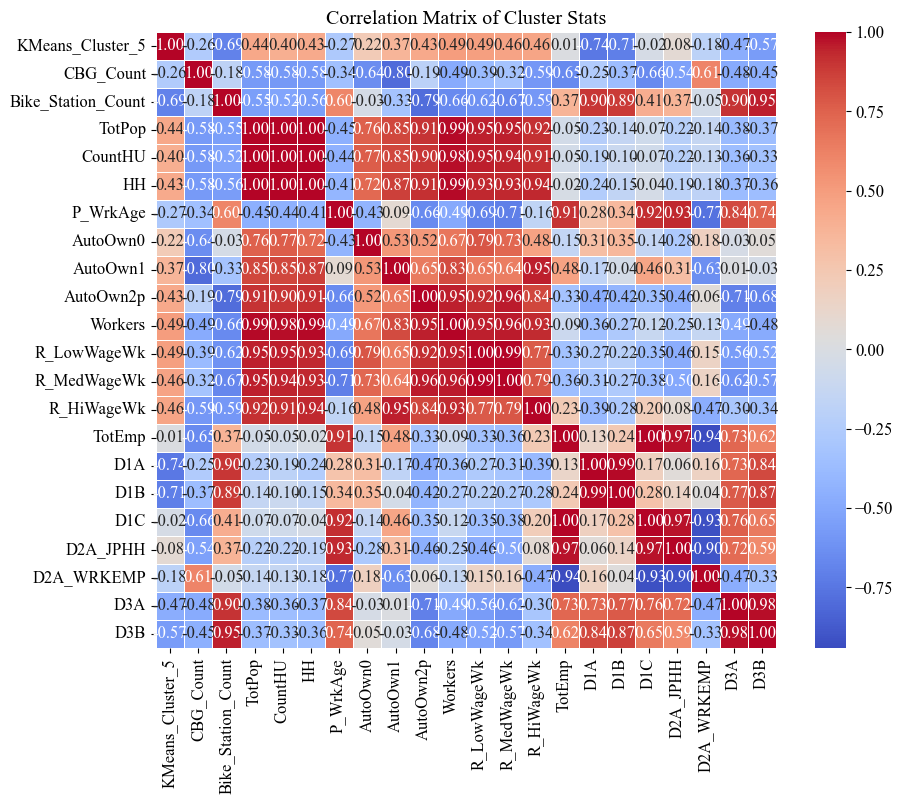

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = cluster_stats.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Cluster Stats')
plt.show()


In [28]:
# Create a new DataFrame with relevant columns
cluster_stats_df = df[['KMeans_Cluster_8'] + selected_columns + ['bike_stations_names']]

# Group by 'KMeans_Cluster_3' and get counts of CBGs in each cluster
cbg_counts = cluster_stats_df.groupby('KMeans_Cluster_8').size().reset_index(name='CBG_Count')

# Group by 'KMeans_Cluster_3' and get unique bike stations in each cluster
bike_station_counts = cluster_stats_df.groupby('KMeans_Cluster_8')['bike_stations_names'].apply(
    lambda x: len(set(item for sublist in x.dropna() for item in sublist))
).reset_index(name='Bike_Station_Count')

# Group by 'KMeans_Cluster_3' and get mean values for other attributes
other_stats = cluster_stats_df.groupby('KMeans_Cluster_8').agg({
    **{col: 'mean' for col in selected_columns if col != 'bike_stations_names'},
}).reset_index()

# Merge the results
cluster_stats = pd.merge(cbg_counts, bike_station_counts, on='KMeans_Cluster_8', how='left')
cluster_stats = pd.merge(cluster_stats, other_stats, on='KMeans_Cluster_8', how='left')

# Print or use the cluster_stats DataFrame as needed
print(cluster_stats)
cluster_stats.to_csv('generated/cluster_stats_8.csv', index=False)


   KMeans_Cluster_8  CBG_Count  Bike_Station_Count       TotPop     CountHU  \
0                 1          6                  19  1031.000000  685.166667   
1                 2         97                   0  1188.948454  571.731959   
2                 3        118                  12   632.177966  353.466102   
3                 4         29                  14   931.413793  433.689655   
4                 5         24                   0  2084.875000  962.375000   
5                 6          6                   0   758.500000  395.833333   
6                 7          1                   1   219.000000   11.000000   
7                 8         64                  22  1292.765625  730.546875   

           HH  P_WrkAge    AutoOwn0    AutoOwn1   AutoOwn2p  ...  R_MedWageWk  \
0  610.000000  0.817500  103.333333  351.000000  155.666667  ...   130.500000   
1  519.639175  0.628577   43.711340  197.639175  278.288660  ...   173.969072   
2  279.855932  0.651432   60.957627  119.8728

In [29]:
print(df[['D4A', 'D4C', 'D4D']].dtypes)


D4A    float64
D4C    float64
D4D    float64
dtype: object


In [30]:
# No transit data blocks
count_negative_99999 = df[df.isin([-9.9999e+04]).any(axis=1)].shape[0]
print(f'Number of rows with -9.9999e+04 in D4A, D4C, or D4D: {count_negative_99999}')
filtered_df = df[(df['D4A'] == -9.9999e+04) | (df['D4C'] == -9.9999e+04) | (df['D4D'] == -9.9999e+04)]
filtered_df.shape

Number of rows with -9.9999e+04 in D4A, D4C, or D4D: 27


(27, 132)

In [31]:
import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
# Create a KeplerGl map
map_filtered = KeplerGl(height=500)

# Add the filtered data to the map
map_filtered.add_data(data=filtered_df, name='filtered_census_blocks')

# Display the map
map_filtered


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'filtered_census_blocks': {'index': [54, 58, 64, 79, 81, 125, 152, 171, 172, 174, 188, 255, 273…

In [32]:
"""
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_selected.columns)
cluster_centers_transposed = cluster_centers.T
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers_transposed, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.title('Average Feature Values Across Clusters')
plt.show()
"""

'\ncluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_selected.columns)\ncluster_centers_transposed = cluster_centers.T\nplt.figure(figsize=(12, 8))\nsns.heatmap(cluster_centers_transposed, cmap=\'viridis\', annot=True, fmt=".2f", linewidths=.5)\nplt.xlabel(\'Cluster\')\nplt.ylabel(\'Feature\')\nplt.title(\'Average Feature Values Across Clusters\')\nplt.show()\n'

Vis

In [33]:

 
# Load your CSV data
#df = pd.read_csv('kmeans_ohky_trimmed_2.csv')
 
# Create a new DataFrame with only 'geometry' and 'cluster' columns
selected_columns_map = ['geometry', 'KMeans_Cluster_5']
df_selected = df[selected_columns_map]
 
# Display the first few rows of your data to verify its structure
# df_selected.head()
 
# Create a Kepler.gl map instance
map_1 = KeplerGl(height=800,
    config={
    "version": "v1",
    "config": {
        "mapState": {
            "latitude": 39.10139,
            "longitude": -84.51164,
            "zoom": 13
        }
    }
}
)
 
 
# Add data to the map for nodes (stations)
map_1.add_data(data=station_info_df, name='stations')
 
 
# Add data to the map
map_1.add_data(data=df_selected, name='cluster')
 
 
 
# Display the map
#map_1.save_to_html(file_name='generated/cluster8.html')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 39.10139, 'longitude': -84.51164, 'zoom'…

In [115]:

 
# Load your CSV data
#df = pd.read_csv('kmeans_ohky_trimmed_2.csv')
 
# Create a new DataFrame with only 'geometry' and 'cluster' columns
selected_columns_ = ['geometry', 'KMeans_Cluster_8']
df_selected = df[selected_columns_]
 
# Display the first few rows of your data to verify its structure
# df_selected.head()
 
# Create a Kepler.gl map instance
map_1 = KeplerGl(height=800,
    config={
    "version": "v1",
    "config": {
        "mapState": {
            "latitude": 39.10139,
            "longitude": -84.51164,
            "zoom": 13
        }
    }
}
)
 
 
# Add data to the map for nodes (stations)
map_1.add_data(data=station_info_df, name='stations')
 
 
# Add data to the map
map_1.add_data(data=df_selected, name='cluster')
 
 
 
# Display the map
#map_1.save_to_html(file_name='generated/cluster8.html')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 39.10139, 'longitude': -84.51164, 'zoom'…

# Rough Work

Random Forest Accuracy: 0.91


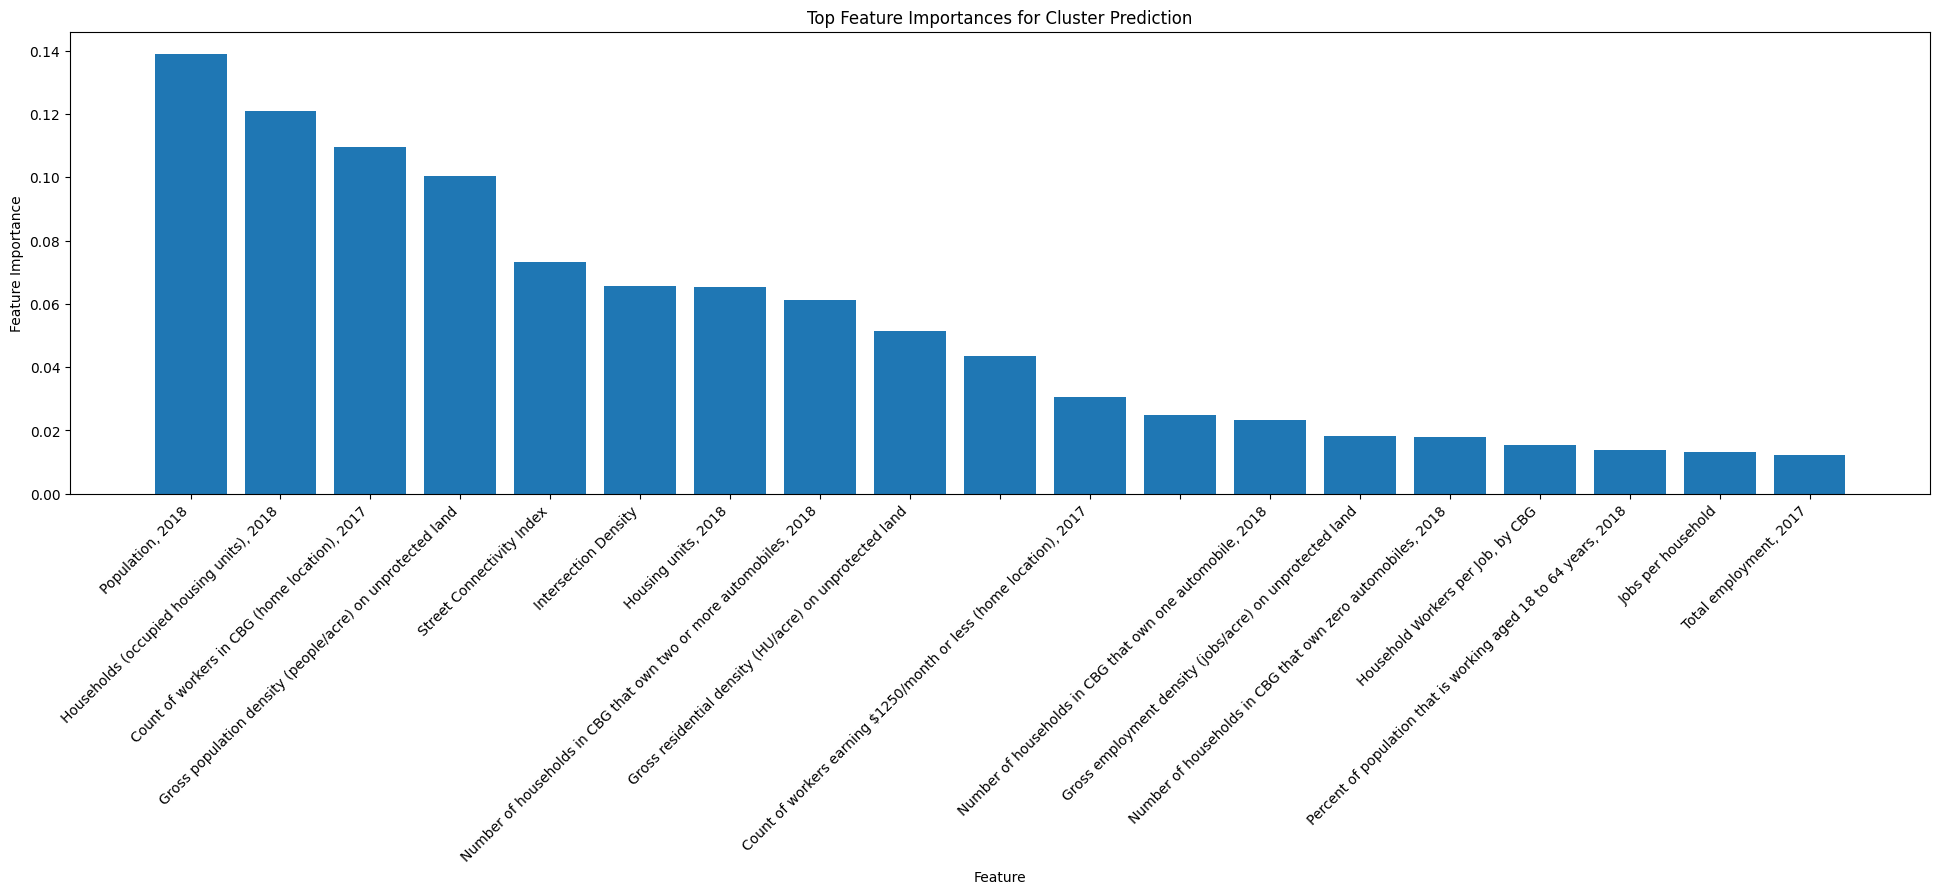

In [116]:

# Split the data into features (X) and target labels (y)
X = df[selected_columns]
y = df['KMeans_Cluster_5']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy (optional)
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy:.2f}')

# Get feature importances from the trained Random Forest model
feature_importances = rf_classifier.feature_importances_
top_n = len(X.columns)
feature_importance_df = pd.DataFrame({'Feature': selected_columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df['Description'] = feature_importance_df['Feature'].map(field_description_dict.get)
feature_importance_df.to_csv("generated/5_cluster_feature_importance.csv", index=False)


top_feature_names = feature_importance_df['Description']

# Plot the top N feature importances and save the plot as an image
plt.figure(figsize=(24, 6))
plt.bar(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Top Feature Importances for Cluster Prediction')
plt.savefig('generated/5_cluster_feature_importance_plot.png')

# Display the plot (optional)
plt.show()



In [117]:
# Plot the top N feature importances
top_n = 20  #len(X.columns)  # Adjust as needed
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), feature_importances[indices][:top_n], align='center')
plt.xticks(range(top_n), X.columns[indices][:top_n], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Top Feature Importances for Cluster Prediction')
plt.show()

NameError: name 'indices' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Your list of field names and descriptions
field_description_list = [
    ('TotPop', 'Population, 2018'),
    ('CountHU', 'Housing units, 2018'),
    ('HH', 'Households (occupied housing units), 2018'),
    ('P_WrkAge', 'Percent of population that is working aged 18 to 64 years, 2018'),
    ('AutoOwn0', 'Number of households in CBG that own zero automobiles, 2018'),
    ('Pct_AO0', 'Percent of zero-car households in CBG, 2018'),
    ('AutoOwn1', 'Number of households in CBG that own one automobile, 2018'),
    ('Pct_AO1', 'Percent of one-car households in CBG, 2018'),
    ('AutoOwn2p', 'Number of households in CBG that own two or more automobiles, 2018'),
    ('Pct_AO2p', 'Percent of two-plus-car households in CBG, 2018'),
    ('Workers', 'Count of workers in CBG (home location), 2017'),
    ('R_LowWageWk', 'Count of workers earning $1250/month or less (home location), 2017'),
    ('R_MedWageWk', 'Count of workers earning more than $1250/month but less than $3333/month (home location), 2017'),
    ('R_HiWageWk', 'Count of workers earning $3333/month or more (home location), 2017'),
    ('R_PCTLOWWAGE', 'Percent of low wage workers in a CBG (home location), 2017'),
    ('TotEmp', 'Total employment, 2017'),
    ('E8_Ret', 'Retail jobs within an 8-tier employment classification scheme (LEHD: CNS07), 2017'),
    ('E8_off', 'Office jobs within an 8-tier employment classification scheme LEHD'),
    ('E8_Ind', 'Industrial jobs within an 8-tier employment classification scheme LEHD'),
    ('E8_Svc', 'Service jobs within an 8-tier employment classification scheme LEHD'),
    ('E8_Ent', 'Entertainment jobs within an 8-tier employment classification scheme LEHD,),
    ('E8_Ed', 'Education jobs within an 8-tier employment classification scheme LEHD'),
    ('E8_Hlth', 'Health care jobs within an 8-tier employment classification scheme LEHD'),
    ('E8_Pub', 'Public administration jobs within an 8-tier employment classification scheme (LEHD: CNS20), 2017'),
    ('E_LowWageWk', '# of workers earning $1250/month or less (work location), 2017'),
    ('E_MedWageWk', '# of workers earning more than $1250/month but less than $3333/month (work location), 2017'),
    ('E_HiWageWk', '# of workers earning $3333/month or more (work location), 2017'),
    ('E_PctLowWage', '% LowWageWk of total #workers in a CBG (work location), 2017'),
    ('D1A', 'Gross residential density (HU/acre) on unprotected land'),
    ('D1B', 'Gross population density (people/acre) on unprotected land'),
    ('D1C', 'Gross employment density (jobs/acre) on unprotected land'),
    ('D1C5_RET', 'Gross retail (5-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C5_OFF', 'Gross office (5-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C5_IND', 'Gross industrial (5-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C5_SVC', 'Gross service (5-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C5_ENT', 'Gross entertainment (5-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_RET', 'Gross retail (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_OFF', 'Gross office (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_IND', 'Gross industrial (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_SVC', 'Gross service (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_ENT', 'Gross entertainment (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_ED', 'Gross education(8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_HLTH', 'Gross health care (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1C8_PUB', 'Gross retail (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D1D', 'Gross activity density (employment + HUs) on unprotected land'),
    ('D1_FLAG', 'Gross density on land with complete flag (1/0)'),
    ('D2A_JPHH', 'Jobs per household'),
    ('D2B_E5MIX', 'Employment type mix, 5-tier scheme'),
    ('D2B_E5MIXA', 'Employment type mix, 5-tier scheme, aggregated'),
    ('D2B_E8MIX', 'Employment type mix, 8-tier scheme'),
    ('D2B_E8MIXA', 'Employment type mix, 8-tier scheme, aggregated'),
    ('D2A_EPHHM', 'Employment per household mix'),
    ('D2C_TRPMX1', 'Trip making pattern mix type 1'),
    ('D2C_TRPMX2', 'Trip making pattern mix type 2'),
    ('D2C_TRIPEQ', 'Trip productions and trip attractions equilibrium index'),
    ('D2R_JOBPOP', 'Job population ratio'),
    ('D2R_WRKEMP', 'Working age population per worker ratio'),
    ('D2A_WRKEMP', 'Household Workers per Job, by CBG'),
    ('D2C_WREMLX', 'Mixed-use (8-tier) employment density (jobs/acre) on unprotected land'),
    ('D3A', 'Street Connectivity Index'),
    ('D3AAO', 'Auto-oriented network density'),
    ('D3AMM', 'Multi-modal network density'),
    ('D3APO', 'Pedestrian-oriented network density'),
    ('D3B', 'Intersection Density'),
    ('D3BAO', 'Auto-oriented intersection density'),
    ('D3BMM3', 'Multi-modal intersection density (3-legged)'),
    ('D3BMM4', 'Multi-modal intersection density (4 or more-legged)'),
    ('D3BPO3', 'Pedestrian-oriented intersection density (3-legged)'),
    ('D3BPO4', 'Pedestrian-oriented intersection density (4 or more-legged)'),
    ('D4A', 'Transit stop proximity'),
    ('D4B025', 'Employment within 1/4 mile of transit stops'),
    ('D4B050', 'Employment within 1/2 mile of transit stops'),
    ('D4C', 'Transit service frequency within 1/4 mile of CBG'),
    ('D4D', 'Transit service frequency density'),
    ('D4E', 'Transit service frequency per capita'),
    ('D5AR', 'Auto-weighted accessibility to jobs'),
    ('D5AE', 'Auto-weighted accessibility to working age population'),
    ('D5BR', 'Transit-weighted accessibility to jobs'),
    ('D5BE', 'Transit-weighted accessibility to working age population'),
    ('D5CR', 'Auto-weighted job accessibility ratio'),
    ('D5CRI', 'Auto-weighted working age population accessibility ratio'),
    ('D5CE', 'Transit-weighted job accessibility ratio'),
    ('D5CEI', 'Transit-weighted working age population accessibility ratio'),
    ('D5DR', 'Auto-weighted accessibility to jobs, distance decay weighted'),
    ('D5DRI', 'Auto-weighted accessibility to working age population, distance decay weighted'),
    ('D5DE', 'Transit-weighted accessibility to jobs, distance decay weighted'),
    ('D5DEI', 'Transit-weighted accessibility to working age population, distance decay weighted'),
    ('D2A_Ranked', 'Quantile ranked order (1-20) of [D2A_EpHHm] from lowest to highest'),
    ('D2B_Ranked', 'Quantile ranked order (1-20) of [D2B_E8MixA] from lowest to highest'),
    ('D3B_Ranked', 'Quantile ranked order (1-20) of [D3B] from lowest to highest'),
    ('D4A_Ranked', 'Quantile ranked order (1,13-20)6 of [D4A] from lowest to highest'),
    ('NatWalkInd', 'Walkability index comprised of weighted sum of the ranked values of .. '),
]
# [D2A_EpHHm] (D2A_Ranked),[D2B_E8MixA] (D2B_Ranked), [D3B] (D3B_Ranked) and [D4A] (D4A_Ranked)
# Create a Python dictionary
field_description_dict = dict(field_description_list)


SyntaxError: unterminated string literal (detected at line 23) (4038213009.py, line 23)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Number of Clusters: 3, Silhouette Score: 0.15299703567323344
Number of Clusters: 5, Silhouette Score: 0.14418474692647826
Number of Clusters: 8, Silhouette Score: 0.12556337535516132
Number of Clusters: 10, Silhouette Score: 0.11009402578917749


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of Clusters: 12, Silhouette Score: 0.12162769928601913
Number of Clusters: 15, Silhouette Score: 0.1260753547112724


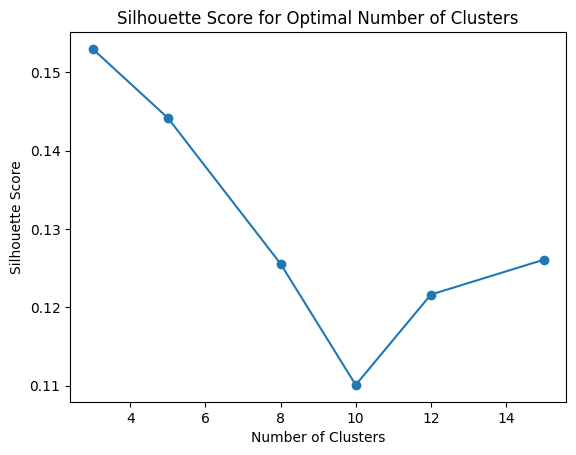

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



# Select columns for clustering
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',
    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE',
    'TotEmp','E8_Ret', 'E8_off', 'E8_Ind',
    'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk',
    'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',
    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',
    'D1D', 'D1_FLAG', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E5MIXA', 'D2B_E8MIX', 'D2B_E8MIXA', 'D2A_EPHHM',
    'D2C_TRPMX1', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP', 'D2C_WREMLX',
    'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4',
    'D4A', 'D4B025', 'D4B050', 'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR',
    'D5CRI', 'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'D2A_Ranked', 'D2B_Ranked',
    'D3B_Ranked', 'D4A_Ranked', 'NatWalkInd'
]
# Create a new DataFrame with selected columns
df_selected = df[selected_columns]

# Standardize the features
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_selected)

# Create an imputer with a strategy of your choice (mean, median, constant, etc.)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your standardized data
df_standardized_no_nan = imputer.fit_transform(df_standardized)

# Perform K-means clustering and choose several cluster values
cluster_values = [3, 5, 8, 10, 12, 15]

# Store silhouette scores for each number of clusters
silhouette_scores = []

for num_clusters in cluster_values:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(df_standardized_no_nan)
    silhouette_avg = silhouette_score(df_standardized_no_nan, labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Number of Clusters: {num_clusters}, Silhouette Score: {silhouette_avg}')

# Plot the silhouette scores
plt.plot(cluster_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

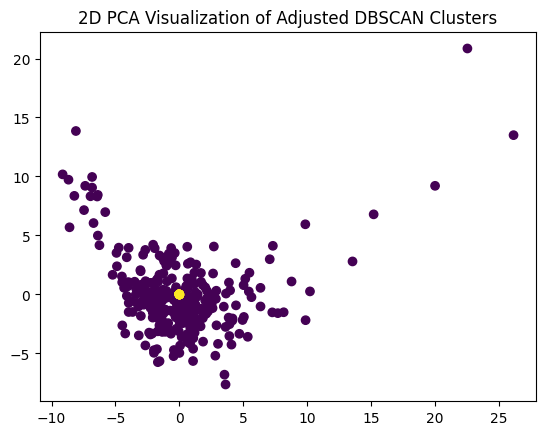

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt




# Select columns for clustering
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',
    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE',
    'TotEmp','E8_Ret', 'E8_off', 'E8_Ind',
    'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk',
    'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',
    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',
    'D1D', 'D1_FLAG', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E5MIXA', 'D2B_E8MIX', 'D2B_E8MIXA', 'D2A_EPHHM',
    'D2C_TRPMX1', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP', 'D2C_WREMLX',
    'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4',
    'D4A', 'D4B025', 'D4B050', 'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR',
    'D5CRI', 'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'D2A_Ranked', 'D2B_Ranked',
    'D3B_Ranked', 'D4A_Ranked', 'NatWalkInd'
]
# Create a new DataFrame with selected columns
df_selected = df[selected_columns]

# Standardize the features
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_selected)

# Create an imputer with a strategy of your choice (mean, median, constant, etc.)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your standardized data
df_standardized_no_nan = imputer.fit_transform(df_standardized)

dbscan = DBSCAN(eps=0.75, min_samples=10)
df['DBSCAN_Clusters'] = dbscan.fit_predict(df_standardized_no_nan)

# Visualize the results (2D PCA plot)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2d = pca.fit_transform(df_standardized_no_nan)

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df['DBSCAN_Clusters'], cmap='viridis')
plt.title('2D PCA Visualization of Adjusted DBSCAN Clusters')
plt.show()

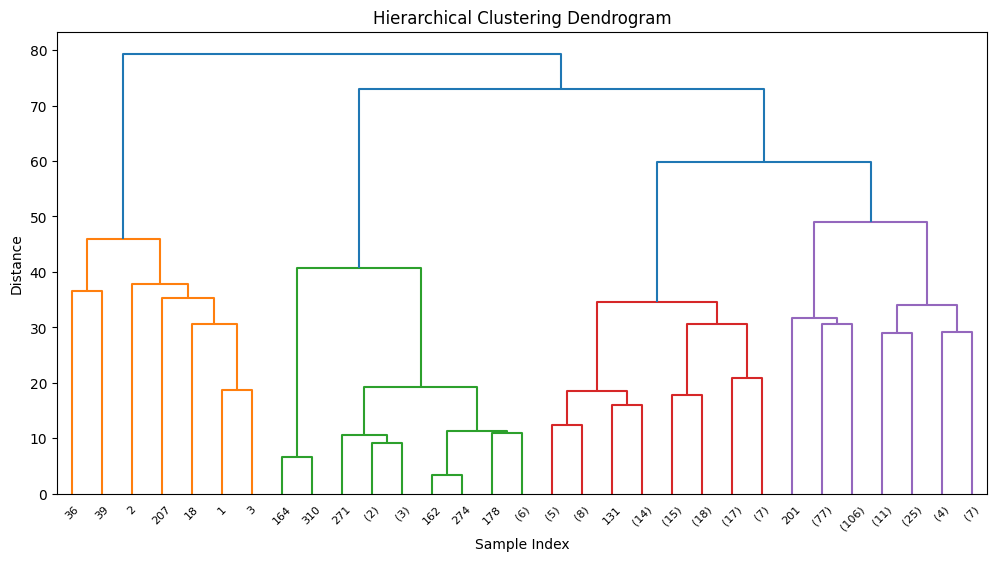

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt




# Select columns for clustering
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',
    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE',
    'TotEmp','E8_Ret', 'E8_off', 'E8_Ind',
    'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk',
    'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',
    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',
    'D1D', 'D1_FLAG', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E5MIXA', 'D2B_E8MIX', 'D2B_E8MIXA', 'D2A_EPHHM',
    'D2C_TRPMX1', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP', 'D2C_WREMLX',
    'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4',
    'D4A', 'D4B025', 'D4B050', 'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR',
    'D5CRI', 'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'D2A_Ranked', 'D2B_Ranked',
    'D3B_Ranked', 'D4A_Ranked', 'NatWalkInd'
]
# Create a new DataFrame with selected columns
df_selected = df[selected_columns]

# Standardize the features
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_selected)

# Create an imputer with a strategy of your choice (mean, median, constant, etc.)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your standardized data
df_standardized_no_nan = imputer.fit_transform(df_standardized)

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Assuming df_standardized_no_nan is your standardized and imputed data
linkage_matrix = linkage(df_standardized_no_nan, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Adjust 'p' as needed
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

# Decide on a distance threshold for cutting the dendrogram
distance_threshold = 150  # Adjust as needed

# Assign cluster labels based on the distance threshold
df['Hierarchical_Clusters'] = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

# Show the plot
plt.show()

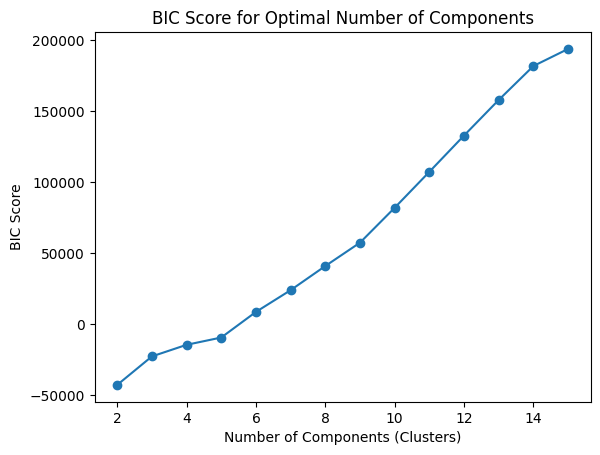

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as pl

# Select columns for clustering
selected_columns = [
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0', 'AutoOwn1', 'Pct_AO1',
    'AutoOwn2p', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE',
    'TotEmp','E8_Ret', 'E8_off', 'E8_Ind',
    'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk',
    'E_PctLowWage', 'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',
    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',
    'D1D', 'D1_FLAG', 'D2A_JPHH', 'D2B_E5MIX', 'D2B_E5MIXA', 'D2B_E8MIX', 'D2B_E8MIXA', 'D2A_EPHHM',
    'D2C_TRPMX1', 'D2C_TRPMX2', 'D2C_TRIPEQ', 'D2R_JOBPOP', 'D2R_WRKEMP', 'D2A_WRKEMP', 'D2C_WREMLX',
    'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', 'D3BMM4', 'D3BPO3', 'D3BPO4',
    'D4A', 'D4B025', 'D4B050', 'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR',
    'D5CRI', 'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'D2A_Ranked', 'D2B_Ranked',
    'D3B_Ranked', 'D4A_Ranked', 'NatWalkInd'
]
# Create a new DataFrame with selected columns
df_selected = df[selected_columns]

# Standardize the features
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_selected)

# Create an imputer with a strategy of your choice (mean, median, constant, etc.)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your standardized data
df_standardized_no_nan = imputer.fit_transform(df_standardized)

from sklearn.mixture import GaussianMixture


# Try different numbers of components and calculate BIC for each
n_components_range = range(2, 16)
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df_standardized_no_nan)
    bic_scores.append(gmm.bic(df_standardized_no_nan))

# Plot BIC scores for different numbers of components
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('BIC Score')
plt.title('BIC Score for Optimal Number of Components')
plt.show()

In [ ]:
# Calculate NaN information
nan_info = df_selected.isna().sum()

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Display the nan_info Series
print(nan_info)

# Reset display options to default values
pd.reset_option('display.max_rows')

TotPop          41
CountHU         41
HH              41
P_WrkAge        41
AutoOwn0        41
Pct_AO0         41
AutoOwn1        41
Pct_AO1         41
AutoOwn2p       41
Pct_AO2p        41
Workers         41
R_LowWageWk     41
R_MedWageWk     41
R_HiWageWk      41
R_PCTLOWWAGE    41
TotEmp          41
E8_Ret          41
E8_off          41
E8_Ind          41
E8_Svc          41
E8_Ent          41
E8_Ed           41
E8_Hlth         41
E8_Pub          41
E_LowWageWk     41
E_MedWageWk     41
E_HiWageWk      41
E_PctLowWage    41
D1A             41
D1B             41
D1C             41
D1C5_RET        41
D1C5_OFF        41
D1C5_IND        41
D1C5_SVC        41
D1C5_ENT        41
D1C8_RET        41
D1C8_OFF        41
D1C8_IND        41
D1C8_SVC        41
D1C8_ENT        41
D1C8_ED         41
D1C8_HLTH       41
D1C8_PUB        41
D1D             41
D1_FLAG         41
D2A_JPHH        41
D2B_E5MIX       41
D2B_E5MIXA      41
D2B_E8MIX       41
D2B_E8MIXA      41
D2A_EPHHM       41
D2C_TRPMX1  

In [ ]:
df.to_csv('generated/kmeans_ohky_trimmed.csv', index=False)
